# Portfolio analysis

## Case I : Stock prices from Down-Jones Index

In [49]:
library('dplyr')
library('tidyr')
library('Sim.DiffProc')
library('quadprog')
library('ggplot2')
library('plotly')
options(repr.plot.width=16, repr.plot.height=8)

In [50]:
source('./PortfolioFunctions_v1.r')

In [51]:
stock_prices <- read.csv('./df_DownJones.csv')%>%
  mutate(Date=as.Date(Date,format = "%Y-%m-%d"))
head(stock_prices)

,Date,WMT,MRK,INTC,MSFT,MMM,AAPL,VZ,JNJ,KO,...,NKE,DIS,HD,TRV,RTX,AXP,CVX,JPM,XOM,BA
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1990-01-03,5.890625,13.31250,1.093750,0.619792,20.34375,0.334821,25.57449,7.515625,4.804688,...,0.859375,9.515615,1.870370,15.09375,4.316787,9.076314,17.00000,10.33333,12.3750,21.00000
2,1990-01-04,5.859375,13.10417,1.117188,0.638021,20.50000,0.335938,24.59086,7.531250,4.781250,...,0.841797,9.505339,1.882716,15.37500,4.306954,8.979757,16.78125,10.37500,12.2500,20.91667
3,1990-01-05,5.796875,12.83333,1.109375,0.622396,20.15625,0.337054,24.02878,7.453125,4.742188,...,0.867188,9.536167,1.858025,15.31250,4.306954,8.883201,16.53125,10.41667,12.1875,20.62500
4,1990-01-08,5.875000,13.00000,1.125000,0.631944,20.68750,0.339286,24.22551,7.578125,4.843750,...,0.863281,9.608099,1.839506,15.37500,4.326621,8.818830,16.68750,10.41667,12.3750,20.87500
5,1990-01-09,5.718750,12.89583,1.156250,0.630208,20.68750,0.335938,23.55102,7.343750,4.804688,...,0.847656,9.597823,1.790123,15.43750,4.277454,8.625717,16.56250,10.08333,12.1250,20.62500
6,1990-01-10,5.718750,12.72917,1.125000,0.612847,20.56250,0.321429,22.93273,7.234375,4.773438,...,0.843750,9.289542,1.802469,15.37500,4.257788,8.561346,16.56250,10.04167,12.1875,20.70833


In [12]:
# get portfolio MV model
port.mv <- getPortfolio(base=stock_prices,year_to_start='2000',rebalance_period=24,mod='mv')

Estimated period : 2000-01 
Estimated period : 2002-01 
Estimated period : 2004-01 
Estimated period : 2006-01 
Estimated period : 2008-01 
Estimated period : 2010-01 
Estimated period : 2012-01 
Estimated period : 2014-01 
Estimated period : 2016-01 
Estimated period : 2018-01 
Estimated period : 2020-01 


In [13]:
# get portfolio MV-GBM model
port.mv_gbm <- getPortfolio(base=stock_prices,year_to_start='2000',rebalance_period=24,mod='gbm')

Estimated period : 2000-01 
Estimated period : 2002-01 
Estimated period : 2004-01 
Estimated period : 2006-01 
Estimated period : 2008-01 
Estimated period : 2010-01 
Estimated period : 2012-01 
Estimated period : 2014-01 
Estimated period : 2016-01 
Estimated period : 2018-01 
Estimated period : 2020-01 


In [14]:
#  Portfolio return
names <- c('date','MV','MV-GBM','MV-EW','MV-RW')
portfolio.ret <- data.frame('date' = port.mv$df.port.ret$date,
                       'MV'= port.mv$df.port.ret$min.ret,
                       'MV.GBM'= port.mv_gbm$df.port.ret$min.ret,
                       'MV.EW' = port.mv$df.port.ret$eqw.ret,
                       'MV.RW' = port.mv$df.port.ret$ran.ret)

In [15]:
# Cumulative portfolio
port.cum.ret <- portfolio.ret %>%
  mutate(cum.MV = cumsum(MV),
         cum.MV.GBM = cumsum(MV.GBM),
         cum.MV.EW = cumsum(MV.EW),
         cum.MV.RW = cumsum(MV.RW)) %>%
  dplyr::select(-MV,-MV.GBM,-MV.EW,-MV.RW)

In [16]:
# names
names2 <- c('date','MV-GBM minus MV','MV-GBM minus MV-EW','MV-GBM minus MV-RW')
cum.portfolio.diff <- port.cum.ret %>%
  mutate(MV.GBM_MV = cum.MV.GBM - cum.MV,
         MV.GBM_MV.EW =cum.MV.GBM - cum.MV.EW,
         MV.GBM_MV.RW = cum.MV.GBM - cum.MV.RW)%>%
  dplyr::select(-cum.MV,-cum.MV.GBM,-cum.MV.EW,-cum.MV.RW)

## colnames
colnames(portfolio.ret) <- names
colnames(port.cum.ret) <- names
colnames(cum.portfolio.diff) <- names2

In [17]:
# base cum.ret
base.cum.ret <- port.cum.ret %>%
  gather(key='Modelo',value='cumulative.return',-date)
# base cum.ret.diff
base.portfolio.diff <- cum.portfolio.diff %>%
  gather(key='Modelo',value='cumulative.return.diff',-date)

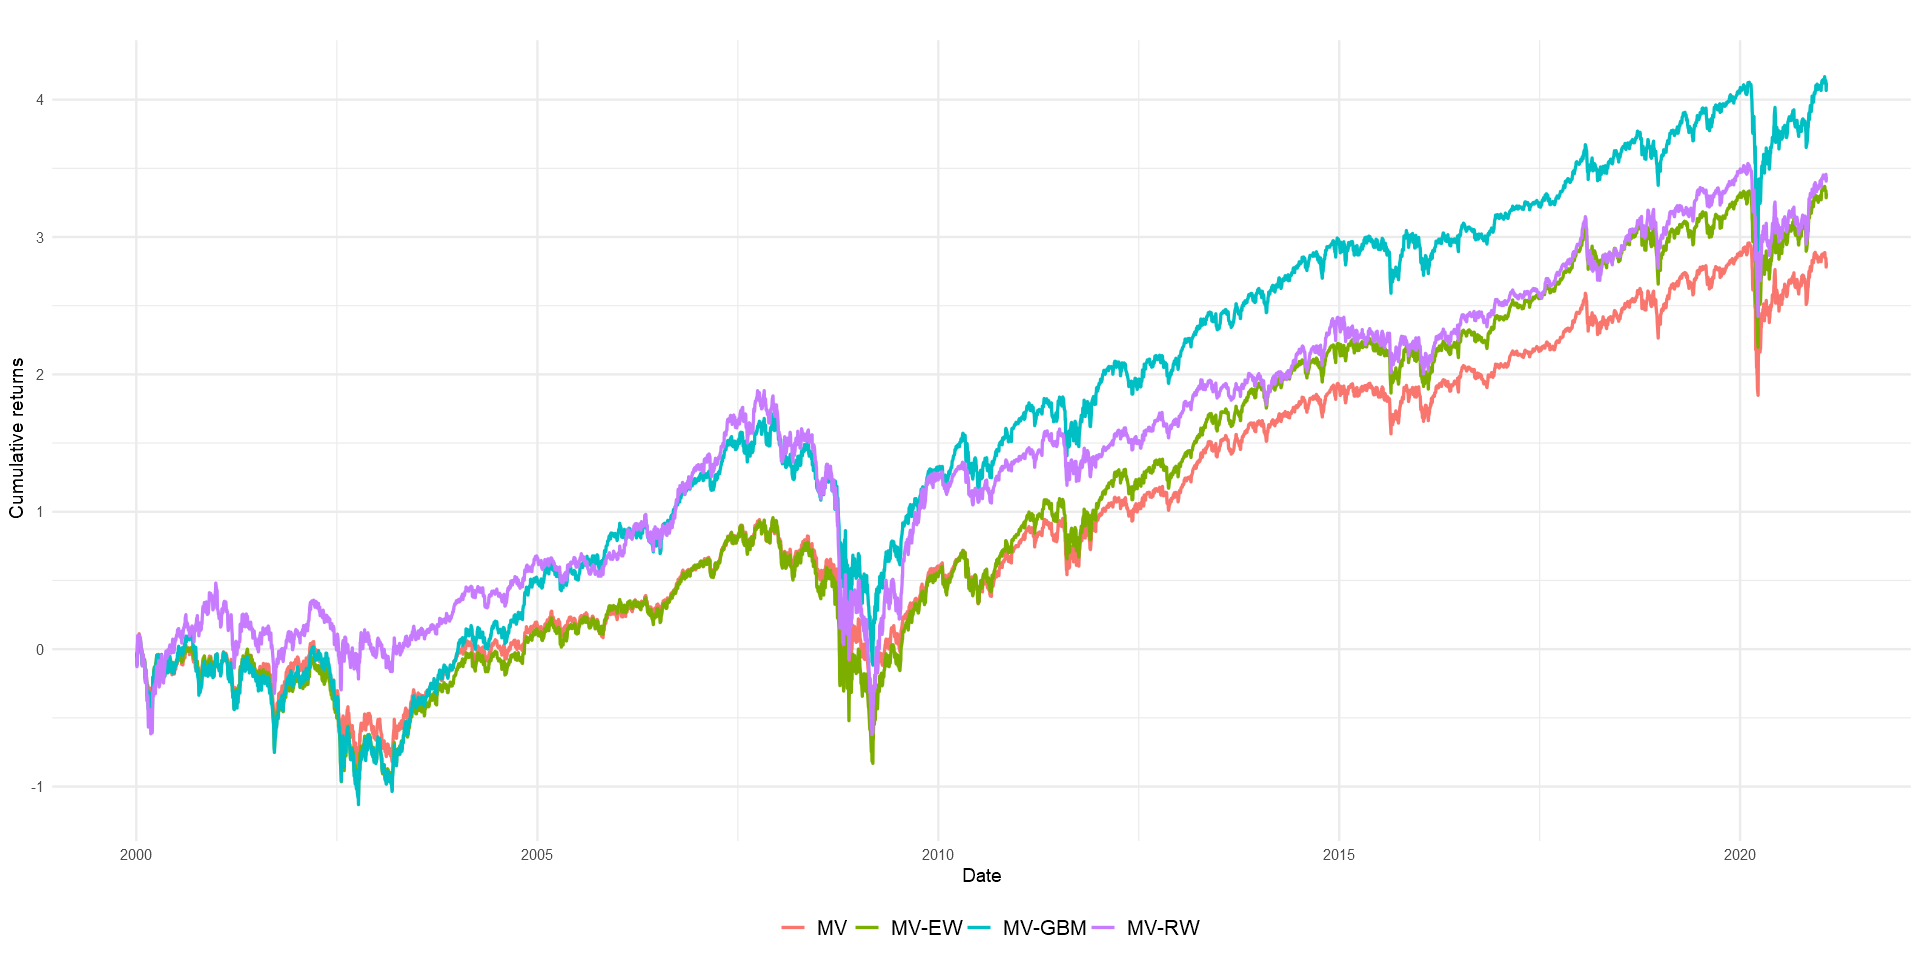

In [52]:
p0 <- ggplot(base.cum.ret , aes(x=date,y=cumulative.return,col=Modelo) )+
  geom_line(size=0.7) +
  theme_minimal() +
  theme(legend.position="bottom",
        legend.title = element_blank(),
        legend.text = element_text(colour="black", size=12)) +
  labs(title="",x='Date',y='Cumulative returns') 
p0

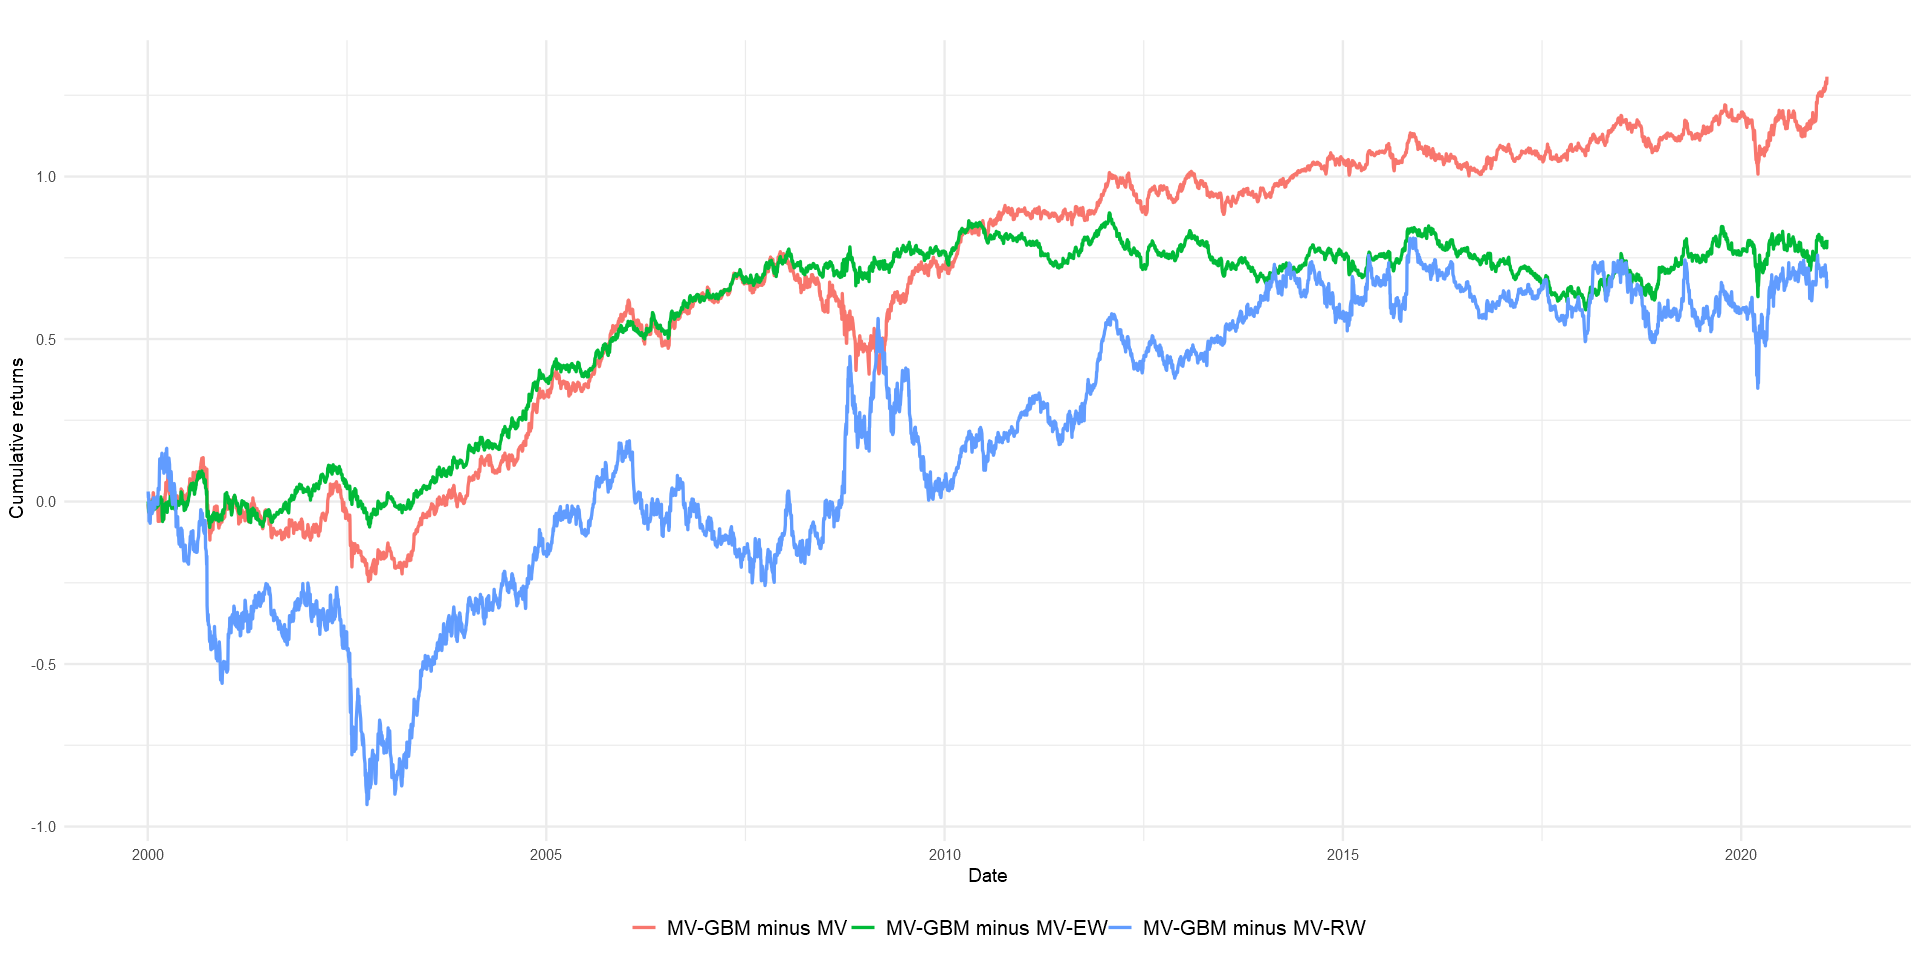

In [48]:
# differences
p1 <- ggplot(base.portfolio.diff , aes(x=date,y=cumulative.return.diff,col=Modelo) )+
  geom_line(size=0.7) +
  theme_minimal() +
  theme(legend.position="bottom",
        legend.title = element_blank(),
        legend.text = element_text(colour="black", size=12)) +
  labs(title="",x='Date',y='Cumulative returns') 
p1

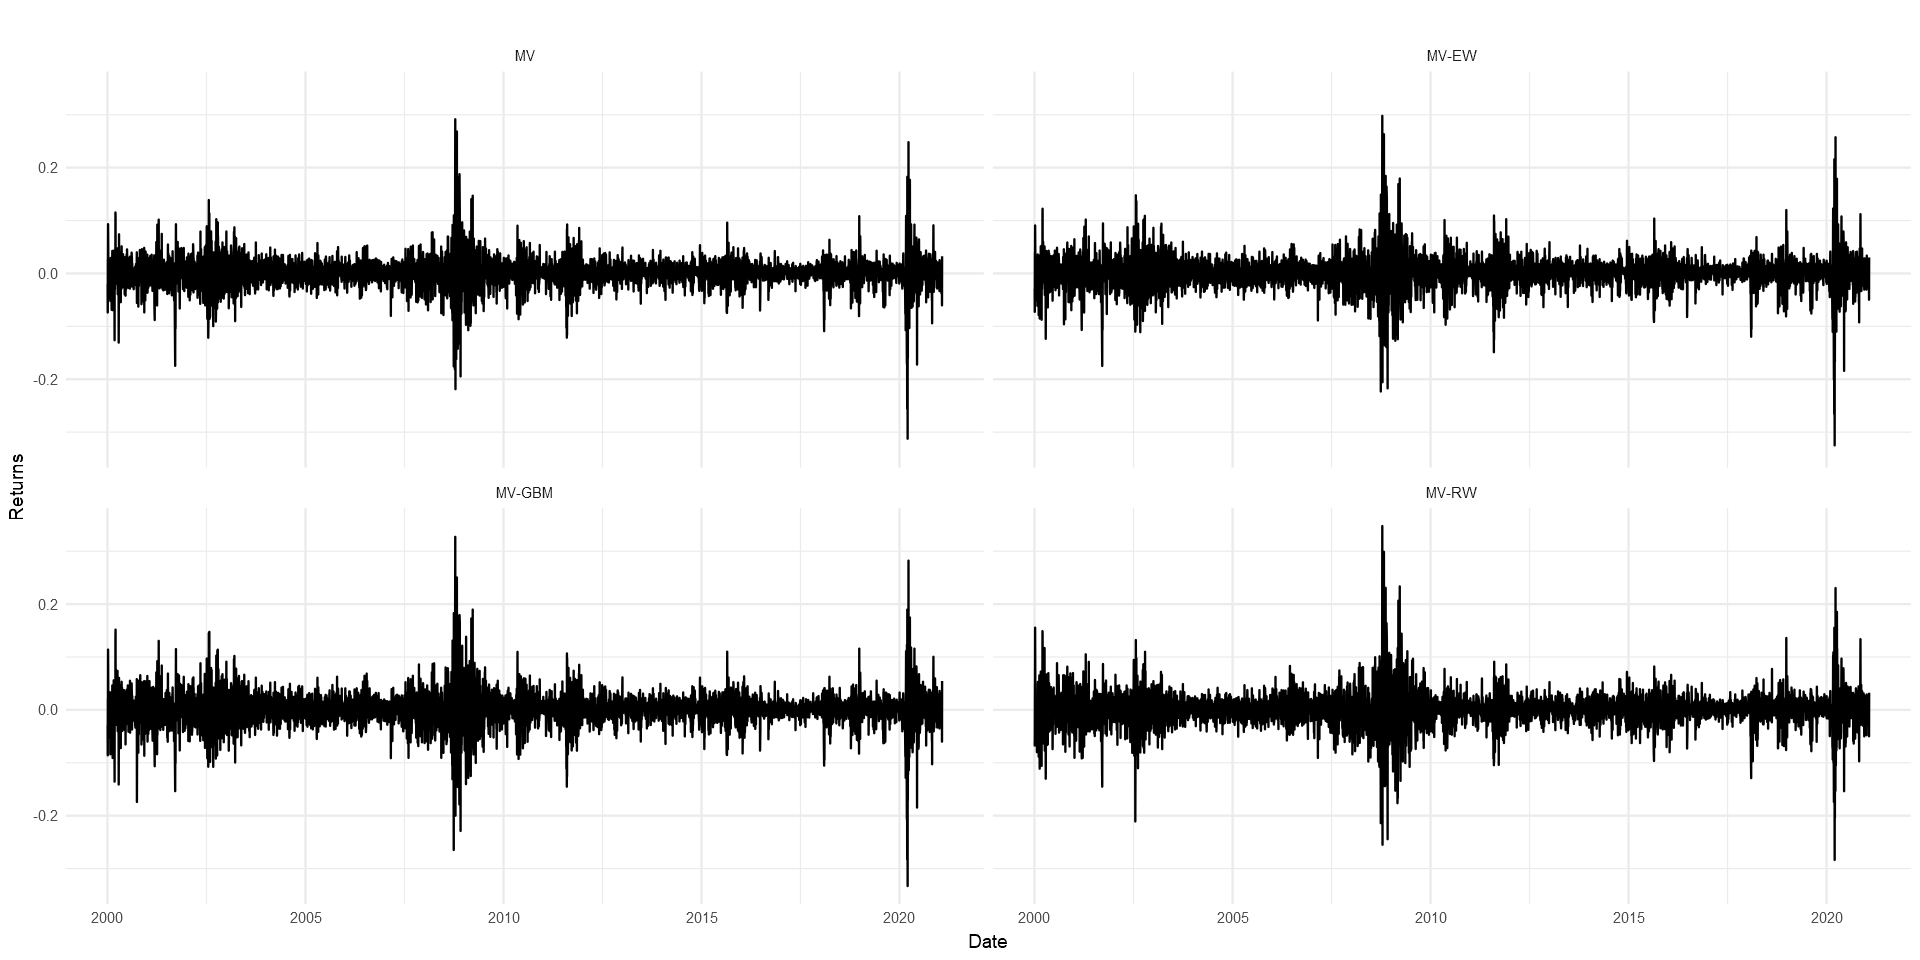

In [53]:
#  returns   
base.ret <- portfolio.ret %>%
  gather(key='Modelo',value='portfolio.return',-date)

# portfolio returns
p2 <- ggplot(base.ret , aes(x=date,y=portfolio.return) )+
  geom_line() +
  theme_minimal() +
  labs(title="",x='Date',y='Returns') +
  facet_wrap(vars(Modelo)) 
p2

In [22]:
# Global Sharpe ratio
mean_port <- base.ret %>% 
  group_by(Modelo) %>% 
  summarize(mean=mean(portfolio.return),
            sd = sd(portfolio.return),
            SharpeRatio = mean/sd) %>%
  ungroup() %>%
  data.frame() %>%
  arrange(desc(SharpeRatio))
mean_port

Modelo,mean,sd,SharpeRatio
<chr>,<dbl>,<dbl>,<dbl>
MV-GBM,0.0007773172,0.03229639,0.02406824
MV-EW,0.0006254553,0.03079890,0.02030771
MV-RW,0.0006486109,0.03212915,0.02018762
MV,0.0005307423,0.02831500,0.01874421


In [23]:
#  Sharpe Ratio df
sharpe.ratio <- portfolio.ret %>% 
  gather(key='Modelo',value='returns',-date) %>%
  mutate(year = substring(date,1,4)) %>% 
  dplyr::select(-date,Modelo,year,returns) %>%
  group_by(Modelo,year) %>%
  summarise(mean=mean(returns),sd=sd(returns)) %>%
  ungroup() %>%
  data.frame() %>%
  mutate(sharpe=mean/sd) %>%
  filter(year < '2021') 

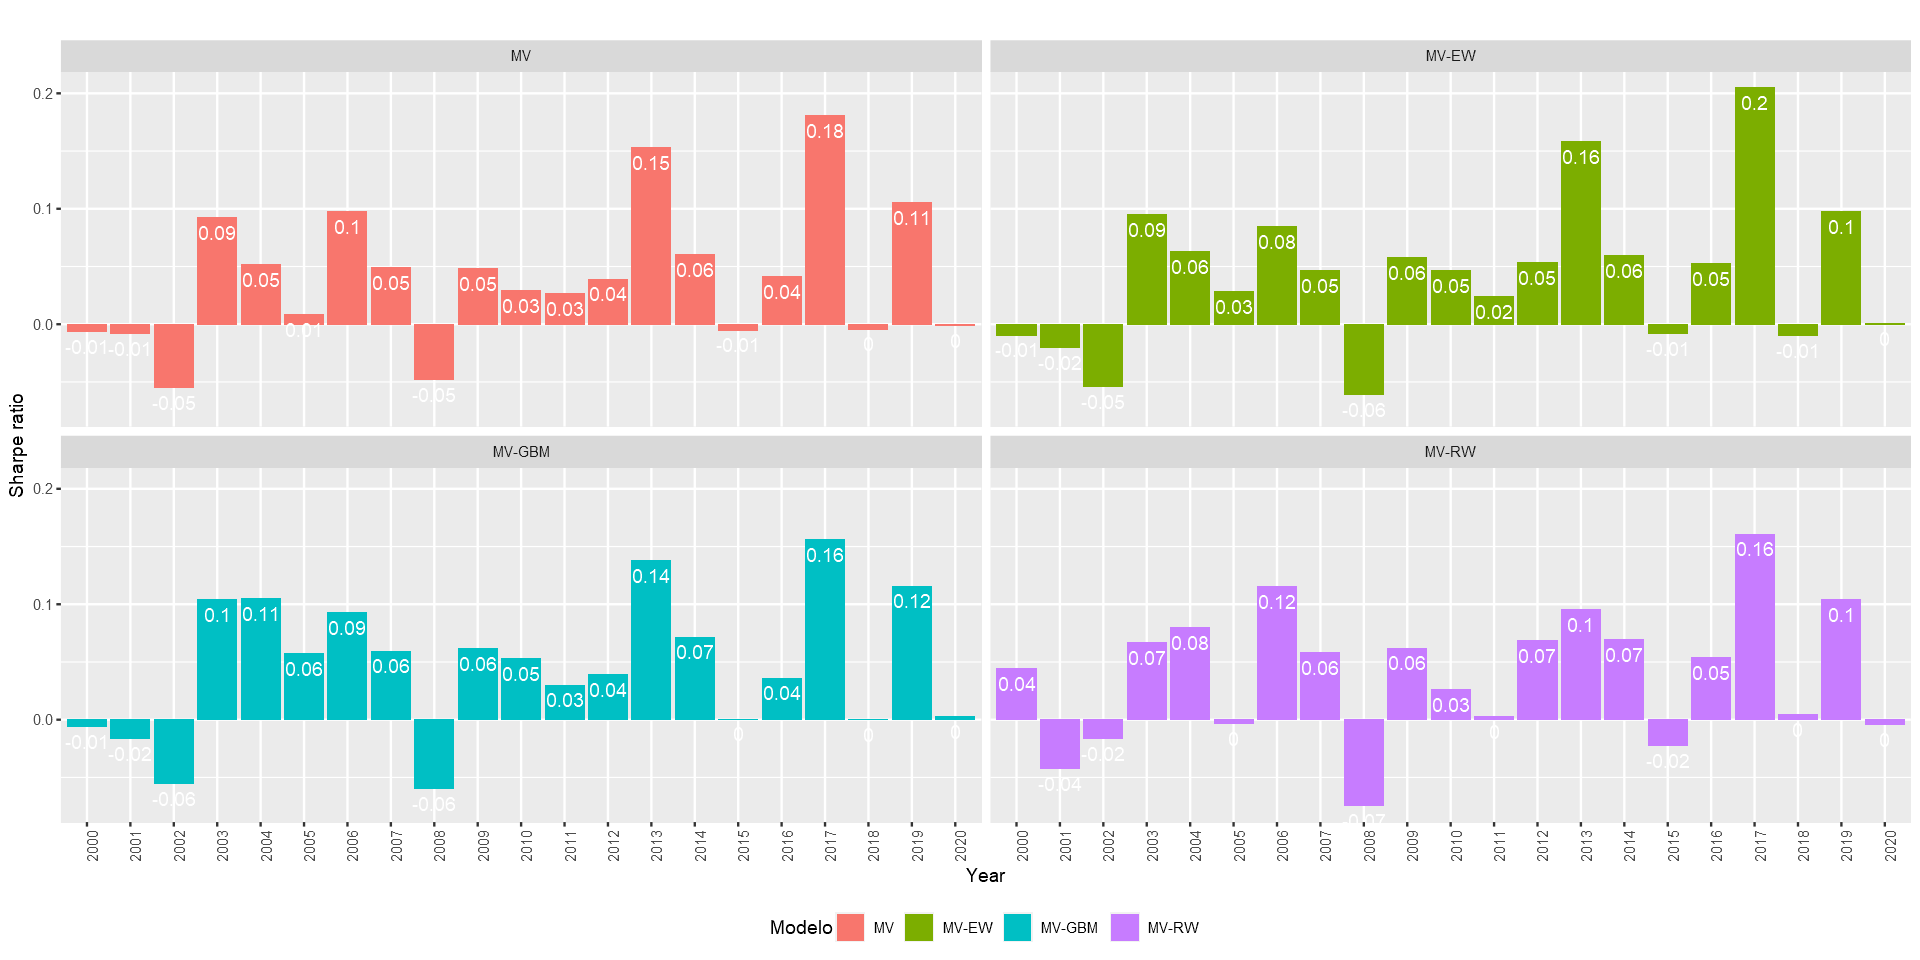

In [47]:
# Sharpe ratio plot
p4 <- ggplot(sharpe.ratio,aes(x=year,y=sharpe,fill=Modelo)) +
  geom_col(position=position_dodge()) +
  labs(title="",x='Year',y='Sharpe ratio') +
  facet_wrap(vars(Modelo)) +
  geom_text(aes(label=round(sharpe,2)), vjust=1.6, color="white", size=4) +
  theme(legend.position="bottom",
        axis.text.x = element_text(angle = 90))
  
p4

In [26]:
# Sharpe ratio table
sharpe.ratio.table <- portfolio.ret %>% 
  gather(key='Modelo',value='returns',-date) %>%
  mutate(year = substring(date,1,4)) %>%  # month = substring(date,6,7)
  dplyr::select(-date,Modelo,year,returns) %>%
  group_by(Modelo,year) %>%
  summarise(mean=mean(returns),sd=sd(returns)) %>%
  ungroup() %>%
  data.frame() %>%
  mutate(sharpe=mean/sd) %>%
  dplyr::select(-mean,-sd) %>%
  filter(year < '2021') %>%
  spread(key=Modelo,value=sharpe)
sharpe.ratio.table

year,MV,MV-EW,MV-GBM,MV-RW
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
2000,-0.006046801,-0.0093659467,-0.005756541,0.044569072
2001,-0.008048197,-0.0199705569,-0.016550089,-0.042225711
2002,-0.054675671,-0.0541965292,-0.055147211,-0.016258132
2003,0.092676915,0.0949603080,0.103764119,0.066715597
2004,0.051487775,0.0631706169,0.105205816,0.079614020
2005,0.008408968,0.0286019333,0.057635544,-0.003590625
2006,0.097910781,0.0845861694,0.092746867,0.115454591
2007,0.049034629,0.0468907542,0.059481001,0.058282261
2008,-0.048082240,-0.0608549746,-0.059539210,-0.074670606


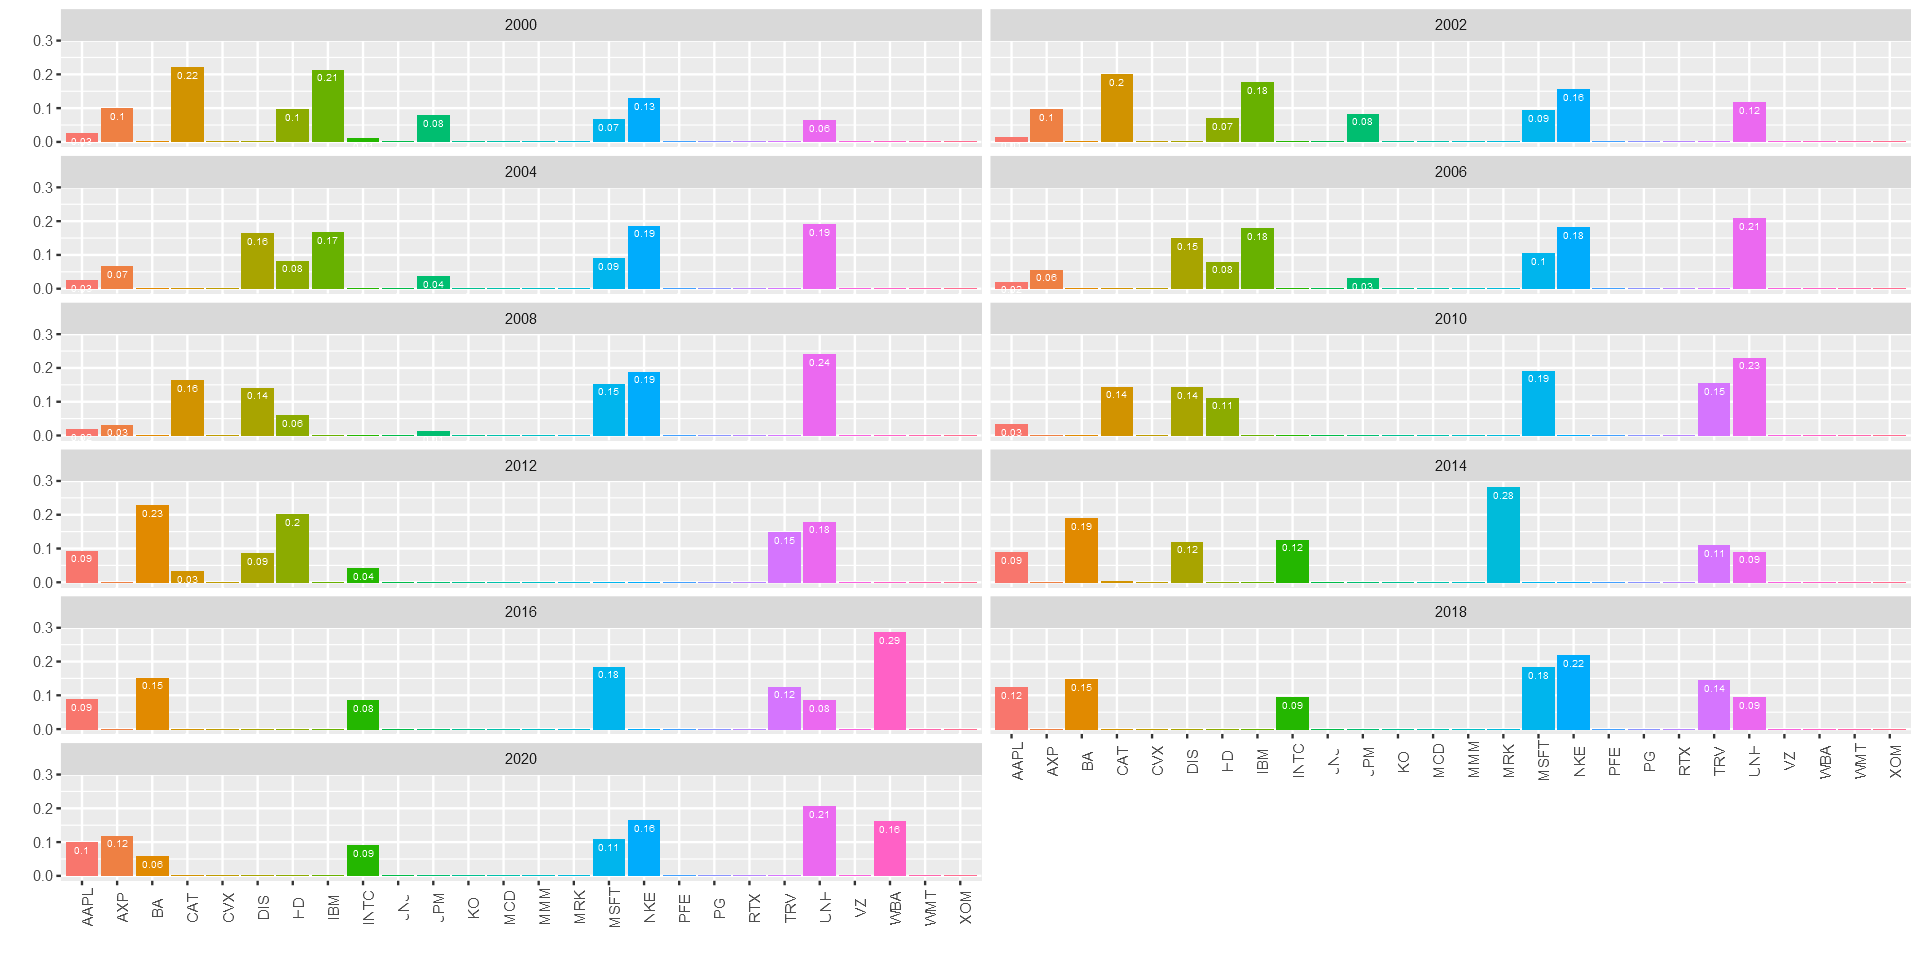

In [44]:
#  Weights
df_weights <- port.mv$df_min_weights %>%
  gather(key='asset',value='valor',-year) %>%
  mutate(year = substring(year,1,4)) 

p5 <- ggplot(df_weights,aes(x=asset,y=valor,fill=asset)) +
  geom_col(position=position_dodge()) +
  labs(x='',y='') +
  facet_wrap(vars(year),ncol=2) +
  geom_text(aes(label=round(valor,2)), vjust=1.6, color="white", size=2) +
  theme(legend.position="none",
        legend.title = element_blank(),
        axis.text.x = element_text(angle = 90))
p5

In [28]:
# weights for each rebalance period
df_weights <- port.mv$df_min_weights %>%
  gather(key='asset',value='valor',-year) %>%
  mutate(year = substring(year,1,4)) %>%
  spread(asset,valor)
df_weights

year,AAPL,AXP,BA,CAT,CVX,DIS,HD,IBM,INTC,...,NKE,PFE,PG,RTX,TRV,UNH,VZ,WBA,WMT,XOM
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2000,0.0253,0.0991,0.0000,0.2204,0,0.0000,0.0965,0.2123,0.0099,...,0.1281,0,0,0,0.0000,0.0632,0,0.0000,0,0
2002,0.0124,0.0962,0.0000,0.1990,0,0.0000,0.0687,0.1757,0.0000,...,0.1550,0,0,0,0.0000,0.1169,0,0.0000,0,0
2004,0.0250,0.0662,0.0000,0.0000,0,0.1623,0.0821,0.1671,0.0000,...,0.1853,0,0,0,0.0000,0.1888,0,0.0000,0,0
2006,0.0195,0.0552,0.0000,0.0000,0,0.1478,0.0788,0.1782,0.0000,...,0.1808,0,0,0,0.0000,0.2068,0,0.0000,0,0
2008,0.0175,0.0310,0.0000,0.1627,0,0.1403,0.0579,0.0000,0.0000,...,0.1881,0,0,0,0.0000,0.2393,0,0.0000,0,0
2010,0.0313,0.0000,0.0000,0.1429,0,0.1418,0.1103,0.0000,0.0000,...,0.0000,0,0,0,0.1536,0.2292,0,0.0000,0,0
2012,0.0921,0.0000,0.2273,0.0309,0,0.0854,0.1998,0.0000,0.0397,...,0.0000,0,0,0,0.1468,0.1779,0,0.0000,0,0
2014,0.0874,0.0000,0.1882,0.0024,0,0.1193,0.0000,0.0000,0.1247,...,0.0000,0,0,0,0.1083,0.0893,0,0.0000,0,0
2016,0.0878,0.0000,0.1506,0.0000,0,0.0000,0.0000,0.0000,0.0833,...,0.0000,0,0,0,0.1244,0.0842,0,0.2863,0,0
